# Robust Workflow

This workflow contains a new function `process_data_steam()` that allows a user to process DataStreams that are not stationary if they choose to do so by setting the flag `operate_safe = False`. With this flag set to False, if a DataStream is not stationary, the code will return the mean based on the last 33% of the data, with an uncertainty of 100%. The dictionary of results that is returned also contains metadata to indicate if the DataStream was processed normally, or if there were exceptions (such as non-stationarity), and how those were mitigated.

This workflow may get added to the QUENDS base class after further testing and refinement.




## Import Required Libraries and Helper Functions

In [1]:
# Import required libraries
import numpy as np
import quends as qnds
import pprint
import matplotlib.pyplot as plt

# Custom class to specify formatting of floats (and tuples of floats) in pprint 
# and limit the number of significant digits in results dictionaries printed to screen
class FloatFormatter(pprint.PrettyPrinter):
    def _format(self, object, stream, indent, allowance, context, level):
        if isinstance(object, tuple):
            stream.write('(')
            for i, item in enumerate(object):
                if isinstance(item, float):
                    stream.write(format(item, '.4g'))
                else:
                    super()._format(item, stream, indent, allowance, context, level)
                if i < len(object) - 1:
                    stream.write(', ')
            stream.write(')')
        elif isinstance(object, float):
            stream.write(format(object, '.4g'))
        else:
            super()._format(object, stream, indent, allowance, context, level)

# use as 'formatter.pprint(object)'
formatter = FloatFormatter(indent=0)




## Paths to data files

In [2]:
# Specify the file paths, and include one file that is deliberately not stationary
data_paths = ["./cgyro/output_nu0_02.csv", "./cgyro/output_nu0_05.csv", "./testdata/non-stat.csv", "./cgyro/output_nu0_10.csv", "./cgyro/output_nu0_50.csv", "./cgyro/output_nu1_0.csv"]
# data_paths = ["./testdata/non-stat.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)


The data stream contains the following variables:
0: Unnamed: 0
1: time
2: Q_D/Q_GBD
3: Q_e/Q_GBD


## Process Files

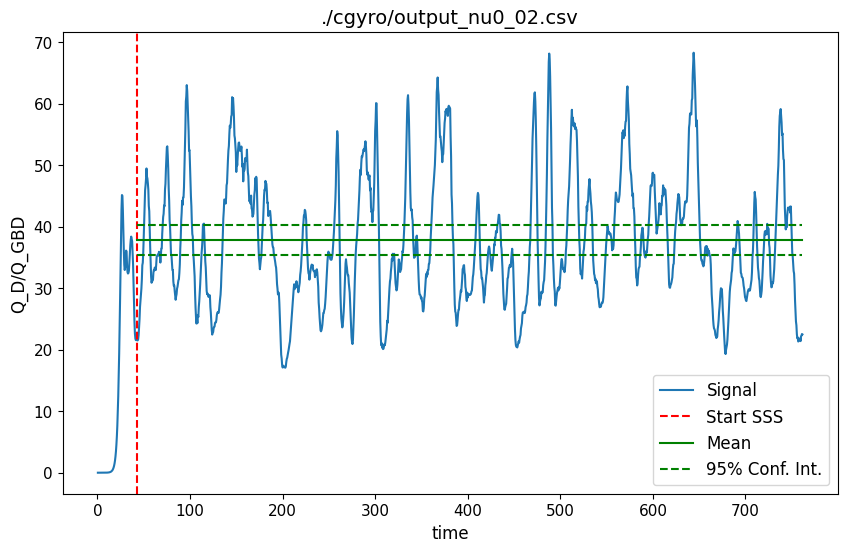

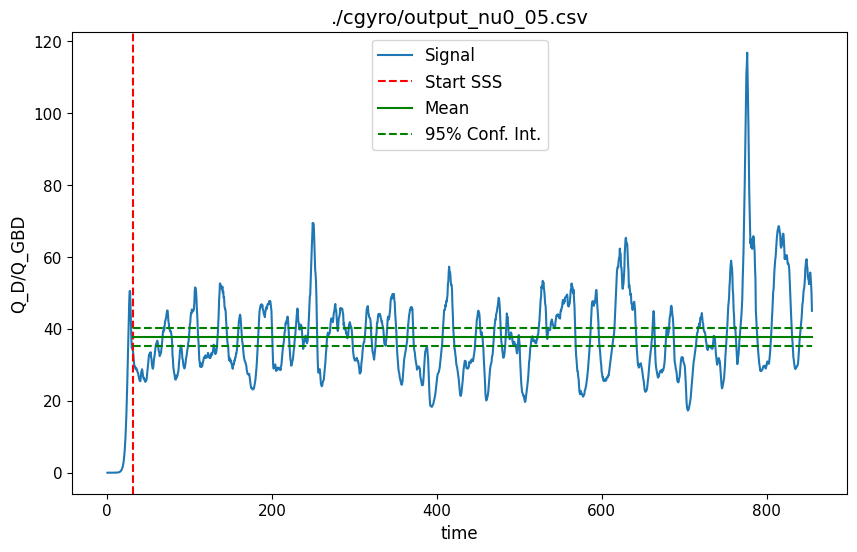

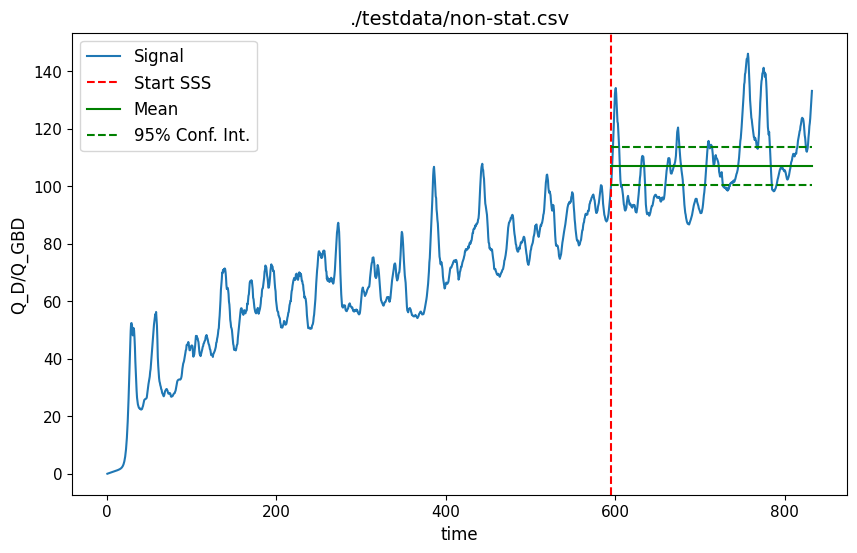

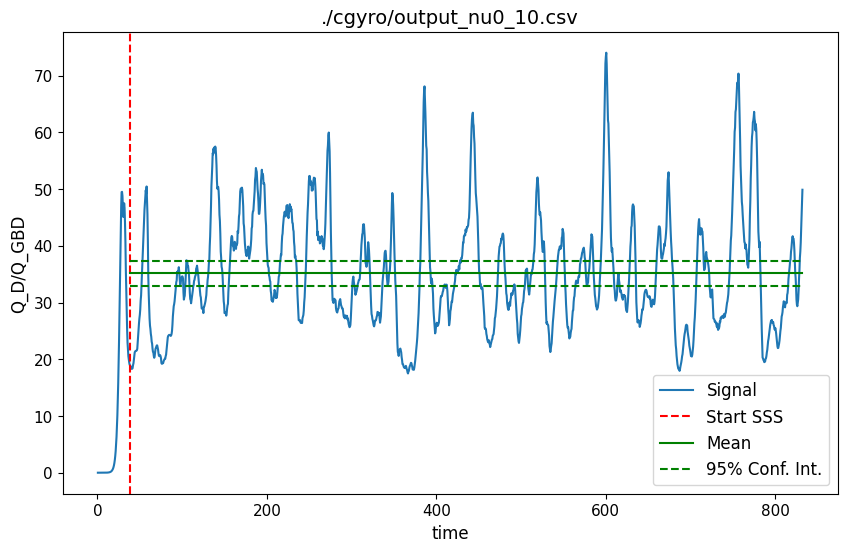

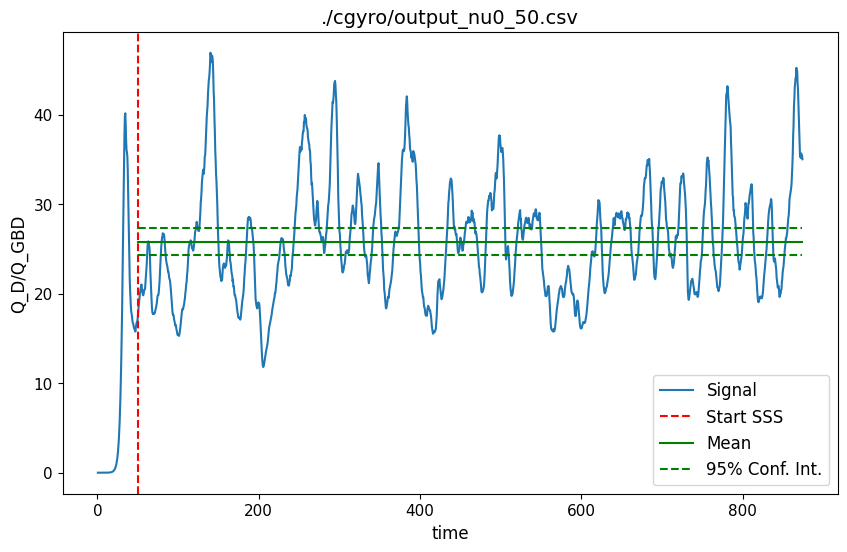

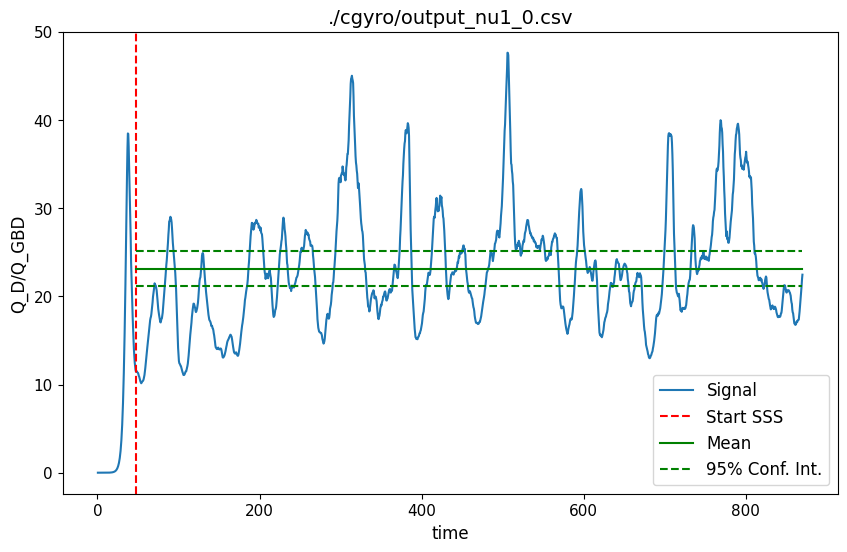

In [3]:
# Set up workflow object
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=0)

# Process files
for data_path in data_paths:
    # Load the data into a data_stream object
    data_stream = qnds.from_csv(data_path)

    # Get statistics
    my_stats = my_wrkflw.process_data_steam(data_stream,col)

    # Plot trace with mean and start of steady state
    if not my_stats[col]["metadata"]["mitigation"] == "Drop":
        my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_path)
    

### Demo a situation where the data is stationary but there is no statistical steady state found due to bad hyperparameters


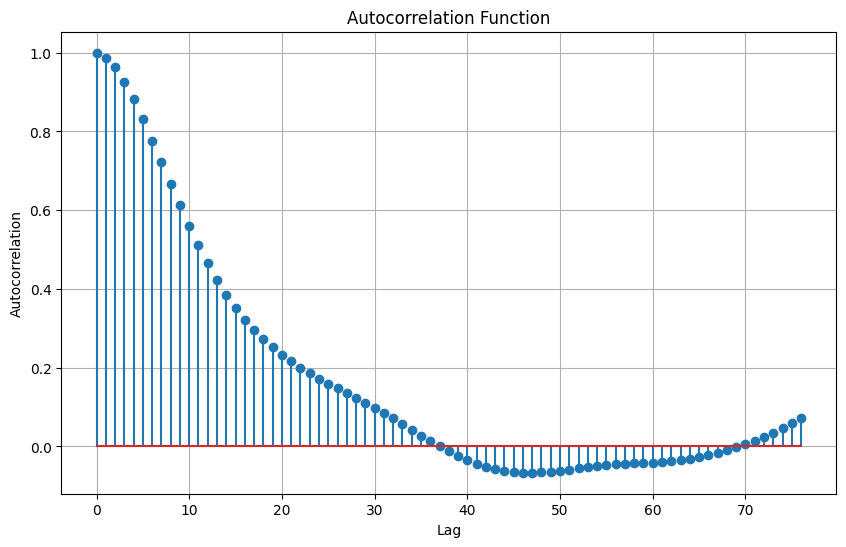

stats decorrelation length 30 gives smoothing window of 30 points.


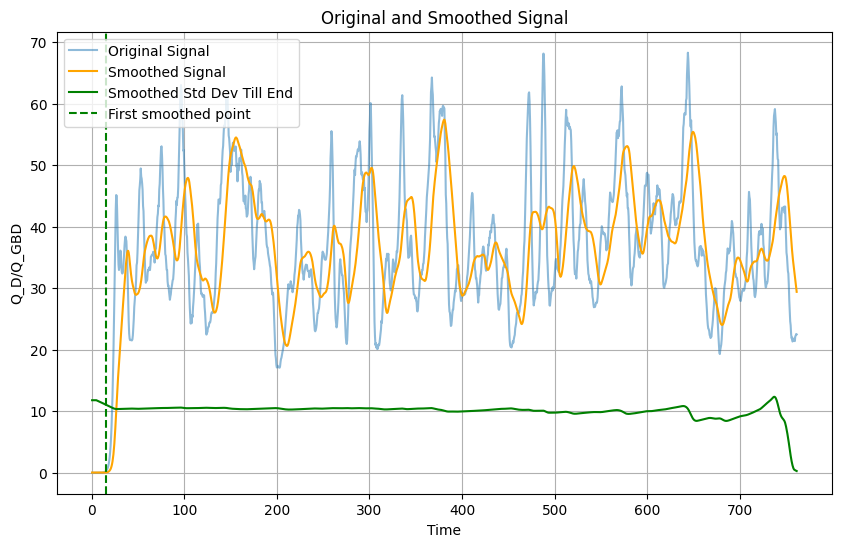

Getting start of SSS based on smoothed signal:
No SSS found based on behavior of mean of smoothed signal.


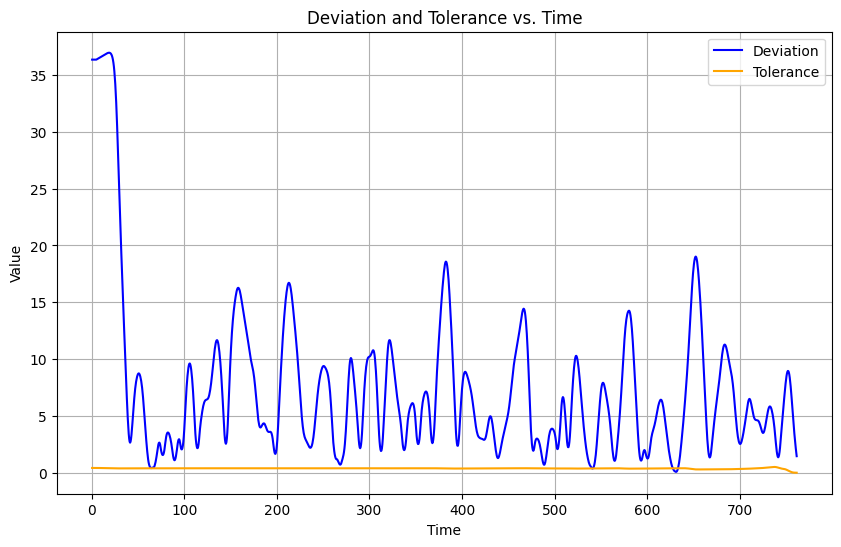

No statistical steady state found after trimming.
Results for ./cgyro/output_nu0_02.csv:
{'Q_D/Q_GBD': {'confidence_interval': (0, 77.97),
             'mean': 38.99,
             'mean_uncertainty': 38.99,
             'metadata': {'mitigation': 'AdHoc', 'status': 'NoStatSteadyState'},
             'sss_start': 508}}


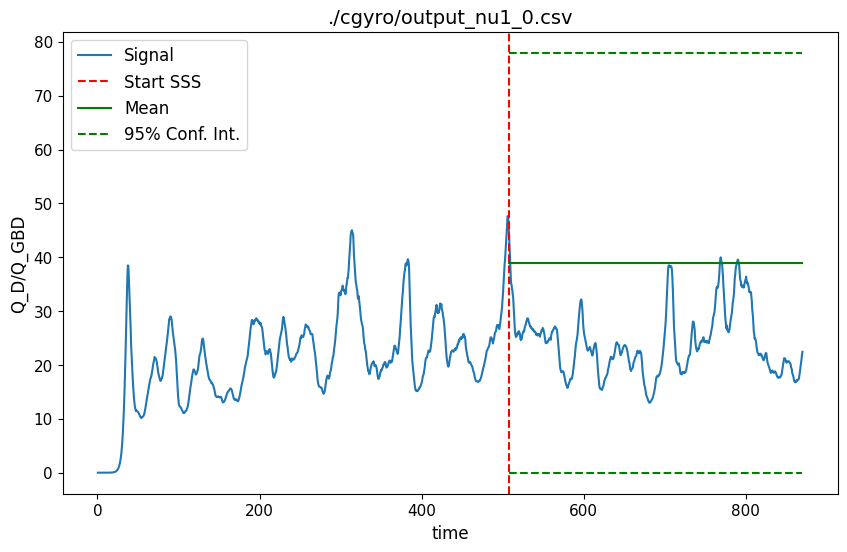

In [4]:
ds0 = qnds.from_csv(data_paths[0])

# Set up workflow object and use very badly chosen hyperparameters
my_wrkflw0 = qnds.RobustWorkflow(operate_safe=False, verbosity=2, max_lag_frac=0.05,decor_multiplier=1.0,std_dev_frac=0.001,fudge_fac=0.0)

# Get statistics
my_stats = my_wrkflw0.process_data_steam(ds0,col)

# Print results
print(f"Results for {data_paths[0]}:") 
formatter.pprint(my_stats)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw0.plot_signal_basic_stats(data_stream,col,my_stats,label=data_path)
